## Obbjetivo:
 O objetivo desse trabalho é entender o impacto de alguns fatores como engenharia e seleção de variáveis e ajuste de hiperparâmetros impactam no desempenho final de um modelo preditivo.

## Problema:
O conjunto de dados "Telco customer churn" se trata de um apanhado de características de clientes de um serviço fictício de internet e telefone chamado Telco.

O problema apresentado é conseguir predizer o comportamento de "Churn", cancelamento do serviço, por parte dos clientes a partir de uma série de informações pessoais e de contrato.

- Classificação Supervisionada Binária

#### O conjunto de dados utilizado está disponível neste link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

#### As análises estão distribuídas em células de texto pelo arquivo no final  (abaixo) das seções. Sempre indicadas com "Análise:" no primeiro parágrafo da célula.

## Hipóteses

- 1 -  Transformar de forma adequada as variáveis categóricas em binárias pode melhorar o desempenho de modelos preditivos nesse problema.

- 2 - Incentivar contratos mais longos pode reduzir a taxa de churn.

- 3 - Usar apenas o undersampling para balancear os dados pode ter impacto positivo em modelos preditivos.

- 4 - É poissível obter o mesmo desempenho de um modelo preditivo usando apenas 4 variáveis explicativas.

## Importações

In [ ]:
# # Importações

import pandas as pd
import numpy as np
import math

# Utilidades
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint
import itertools
from sklearn.metrics import make_scorer, f1_score
from tqdm import tqdm

# Algoritmos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Balanceamento de classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Métricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Random number generation setting
SEED = 144

## Visão geral do conjunto de dados

### GLossário de dados

- CustomerID: ID único de cada clienre.
 - str; apenas valores únicos

- Gender: Gênero biológico.
 - str; Binário: Male, Female

- SeniorCitizen: Idoso.
 - int; Binário: 0, 1

- Partner: Possui parceiro.
 - str; Binário: No, Yes

- Dependants: Possui dependentes.
 - str; Binária: No, Yes

- tenure: Duração da relação com o serviçõ, em meses.
 - int; Numérica: de 0 a 72

- PhoneService: Possui sereviço de telefonia.
 - str; Binária: No, Yes,

- MultipleLines: Possui múltiplas linhas de telefonia.
 - str; Categórica: No, Yes, No phone service

- InternetService: POssui serviço de internet.
 - str, Binária: No, Yes

- OnlineSecurity: Possui serviço de segurança online.
 - str; Categórica: No, Yes, No internet service

- OnlineBackup: Possui serviço de backup online.
 - str; Categórica: No, Yes, No internet service

- DeviceProtection: Possui serviço de proteção de dispositivo.
 - str; Categórica: No, Yes, No internet service

- TechSupport: Possui serviço de suporte técnico.
 - str; Categórica: No, Yes, No internet service

- StreamingTV: Possui serviço de TV por streaming.
 - str; Categórica: No, Yes, No internet service

- StreamingMovies: Possui serviço de filmes por streaming.
 - str; Categórica: No, Yes, No internet service

- Contract: Tipo de contrato.
 - str; Categórica: Month-to-month, One year, Two year

- PaperlessBilling: Optou por modalidade de cobrança eletrônica.
 - str; Binária: No, Yes

- PaymentMethod: Método de pagamento utilizado.
 - str; Categórica: Main check, Electronic check, Bank tranfer (automatic), Credit card (automatic)

- MonthlyCharges: Cobranças mensais.
 - float; Numérica: de 18,25 a 118,75

- TotalCharges: Cobranças totais.
 - float; Numérica: de 18,80 a 8684,80

- Churn: Cancelou o contrato.
 - Variável Alvo; Binária: No, Yes

In [ ]:
# Carregando e obtendo uma visão geral dos dados
df_bronze = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_bronze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Métricas gerais das variáveis numéricas
df_bronze.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Análise:
- Não há valores faltantes no conjunto de dados.

- Não há valores inválidos, NaN ou Null entre as variáveis numéricas.

- As variáveis categóricas e binárias são preenchidas com strings e suas colunas são do tipo "object"

- O tipo da variável "TotalCharges" é "object". Deveria ser float por se tratar de valor monetário.


In [ ]:
# Observando o conjunto de dados
df_bronze.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Buscando linhas duplicadas
print("duplicated rows:", df_bronze.duplicated().sum())

# Buscando IDs duplicados
print("duplicated IDs:", df_bronze["customerID"].duplicated().sum())

duplicated rows: 0
duplicated IDs: 0


In [ ]:
# Observando os valores das variáveis binárias e categóricas
col_names = df_bronze.columns
col_names = col_names.drop(["customerID", "tenure", "MonthlyCharges", "TotalCharges", "MonthlyCharges"])

for col in col_names:
  print("\n",col)
  print(df_bronze[col].unique())



 gender
['Female' 'Male']

 SeniorCitizen
[0 1]

 Partner
['Yes' 'No']

 Dependents
['No' 'Yes']

 PhoneService
['No' 'Yes']

 MultipleLines
['No phone service' 'No' 'Yes']

 InternetService
['DSL' 'Fiber optic' 'No']

 OnlineSecurity
['No' 'Yes' 'No internet service']

 OnlineBackup
['Yes' 'No' 'No internet service']

 DeviceProtection
['No' 'Yes' 'No internet service']

 TechSupport
['No' 'Yes' 'No internet service']

 StreamingTV
['No' 'Yes' 'No internet service']

 StreamingMovies
['No' 'Yes' 'No internet service']

 Contract
['Month-to-month' 'One year' 'Two year']

 PaperlessBilling
['Yes' 'No']

 PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

 Churn
['No' 'Yes']


In [ ]:
# Obtendo uma visão geral das variáveis categóricas

df_bronze.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


Análise:
- AS variáveis categóricas não possuem valores inválidos.

- O conjunto de dados em geral parece balanceado. Apenas algumas variáveis possuem desbalanceamento.

- A variável alvo está desbalanceada. Apresenta maior quantidade de valores negativos ("no" ou 0). Essa informação é bastante importante, principalmente para treino de modelos de Machine Learning.

### Visualizing the data

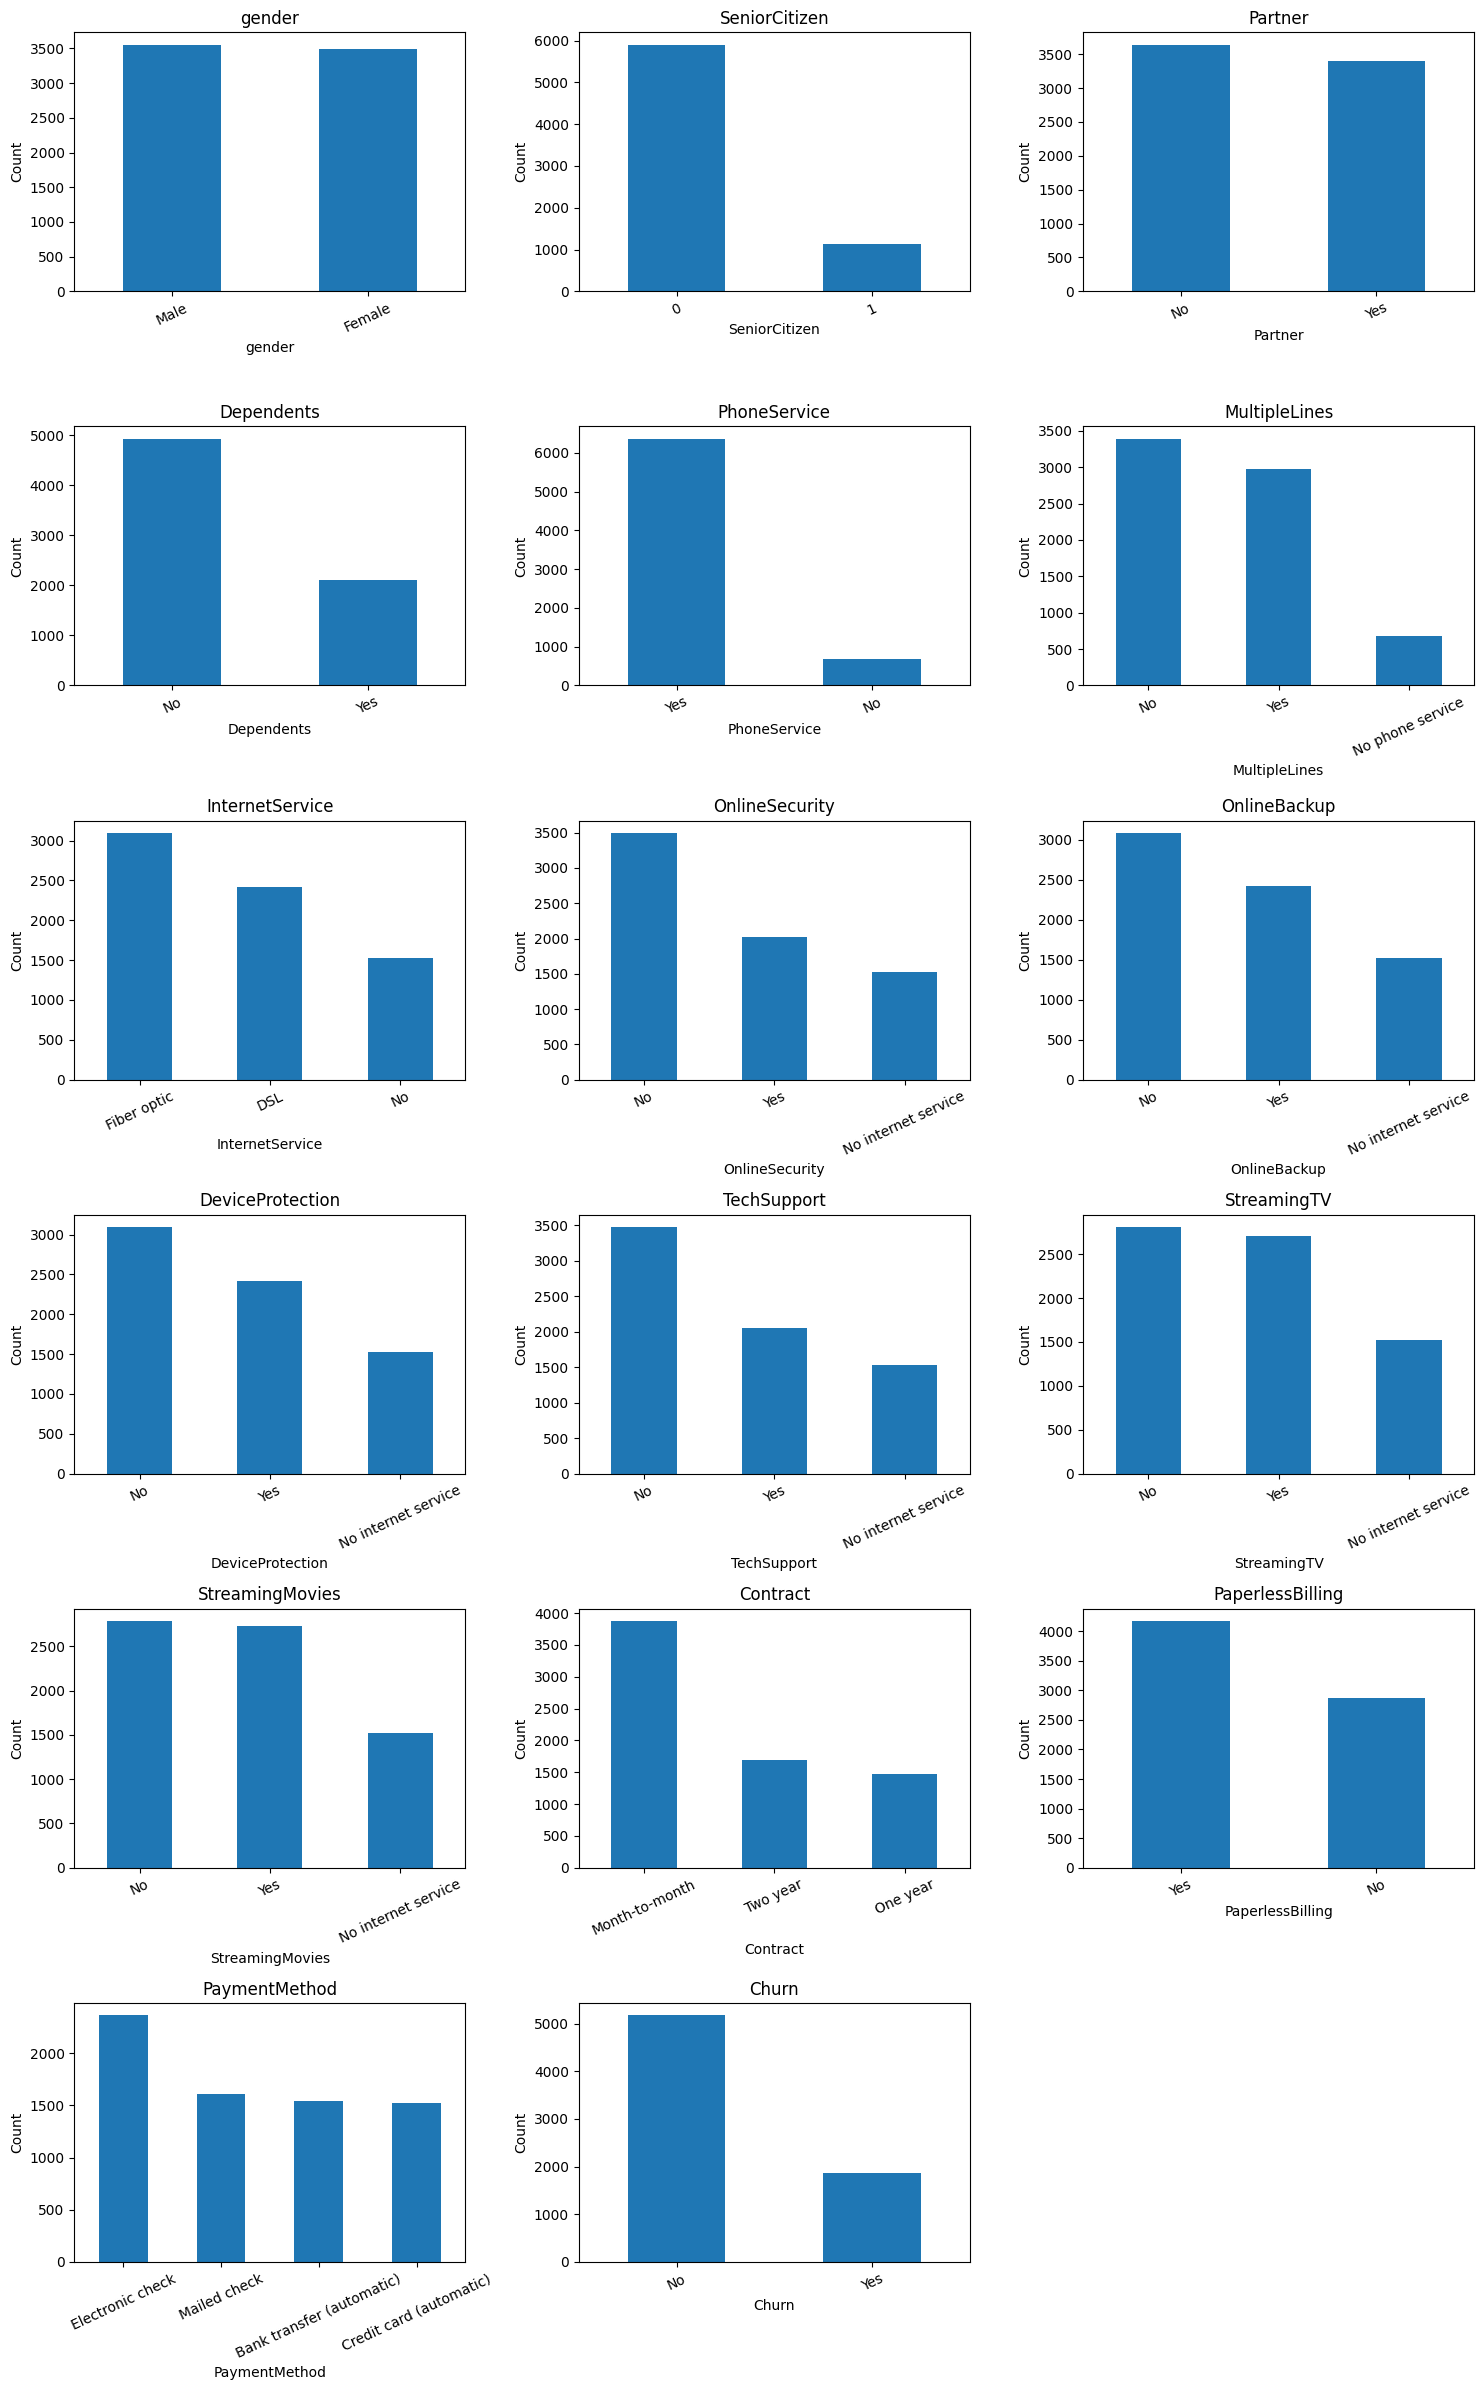

In [ ]:
cat_cols = df_bronze.columns
cat_cols = cat_cols.drop(["customerID", "tenure", "TotalCharges", "MonthlyCharges"])

n_cols = 3
n_rows = -(-len(cat_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df_bronze[col].value_counts().plot(kind='bar', ax=axes[i], title=col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=25)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Análise:
- Visualizar as distribuições dos dados é importante para compreender melhor o conjunto como um todo. Alguns insights podem ser extraídos dessa visualização:

 - Existem variáveis preenchidas como "no internet service". Nesse caso, talvez seja interessante transformar esses valores em "no" já que, na prátrica, quem não possui internet consequentemente não possuirá assinatura de um serviço de streaming. porém, deve-se atentar aos dados. É importante entender o comportamento das categorias em relação à variável alvop ("churn") antes de qualquer manipulação dos dados.
 - De forma semelhante, a variável "InternetService" possui as categorias "DSL" e "fiber optic", as duas indicam que o cliente possui serviço de internet. Existe a possibilidade de unir essas categorias para simplificar os daodos, porém é importante saber se o comportamento dos clientes nessas duas categorias são semelhantes.

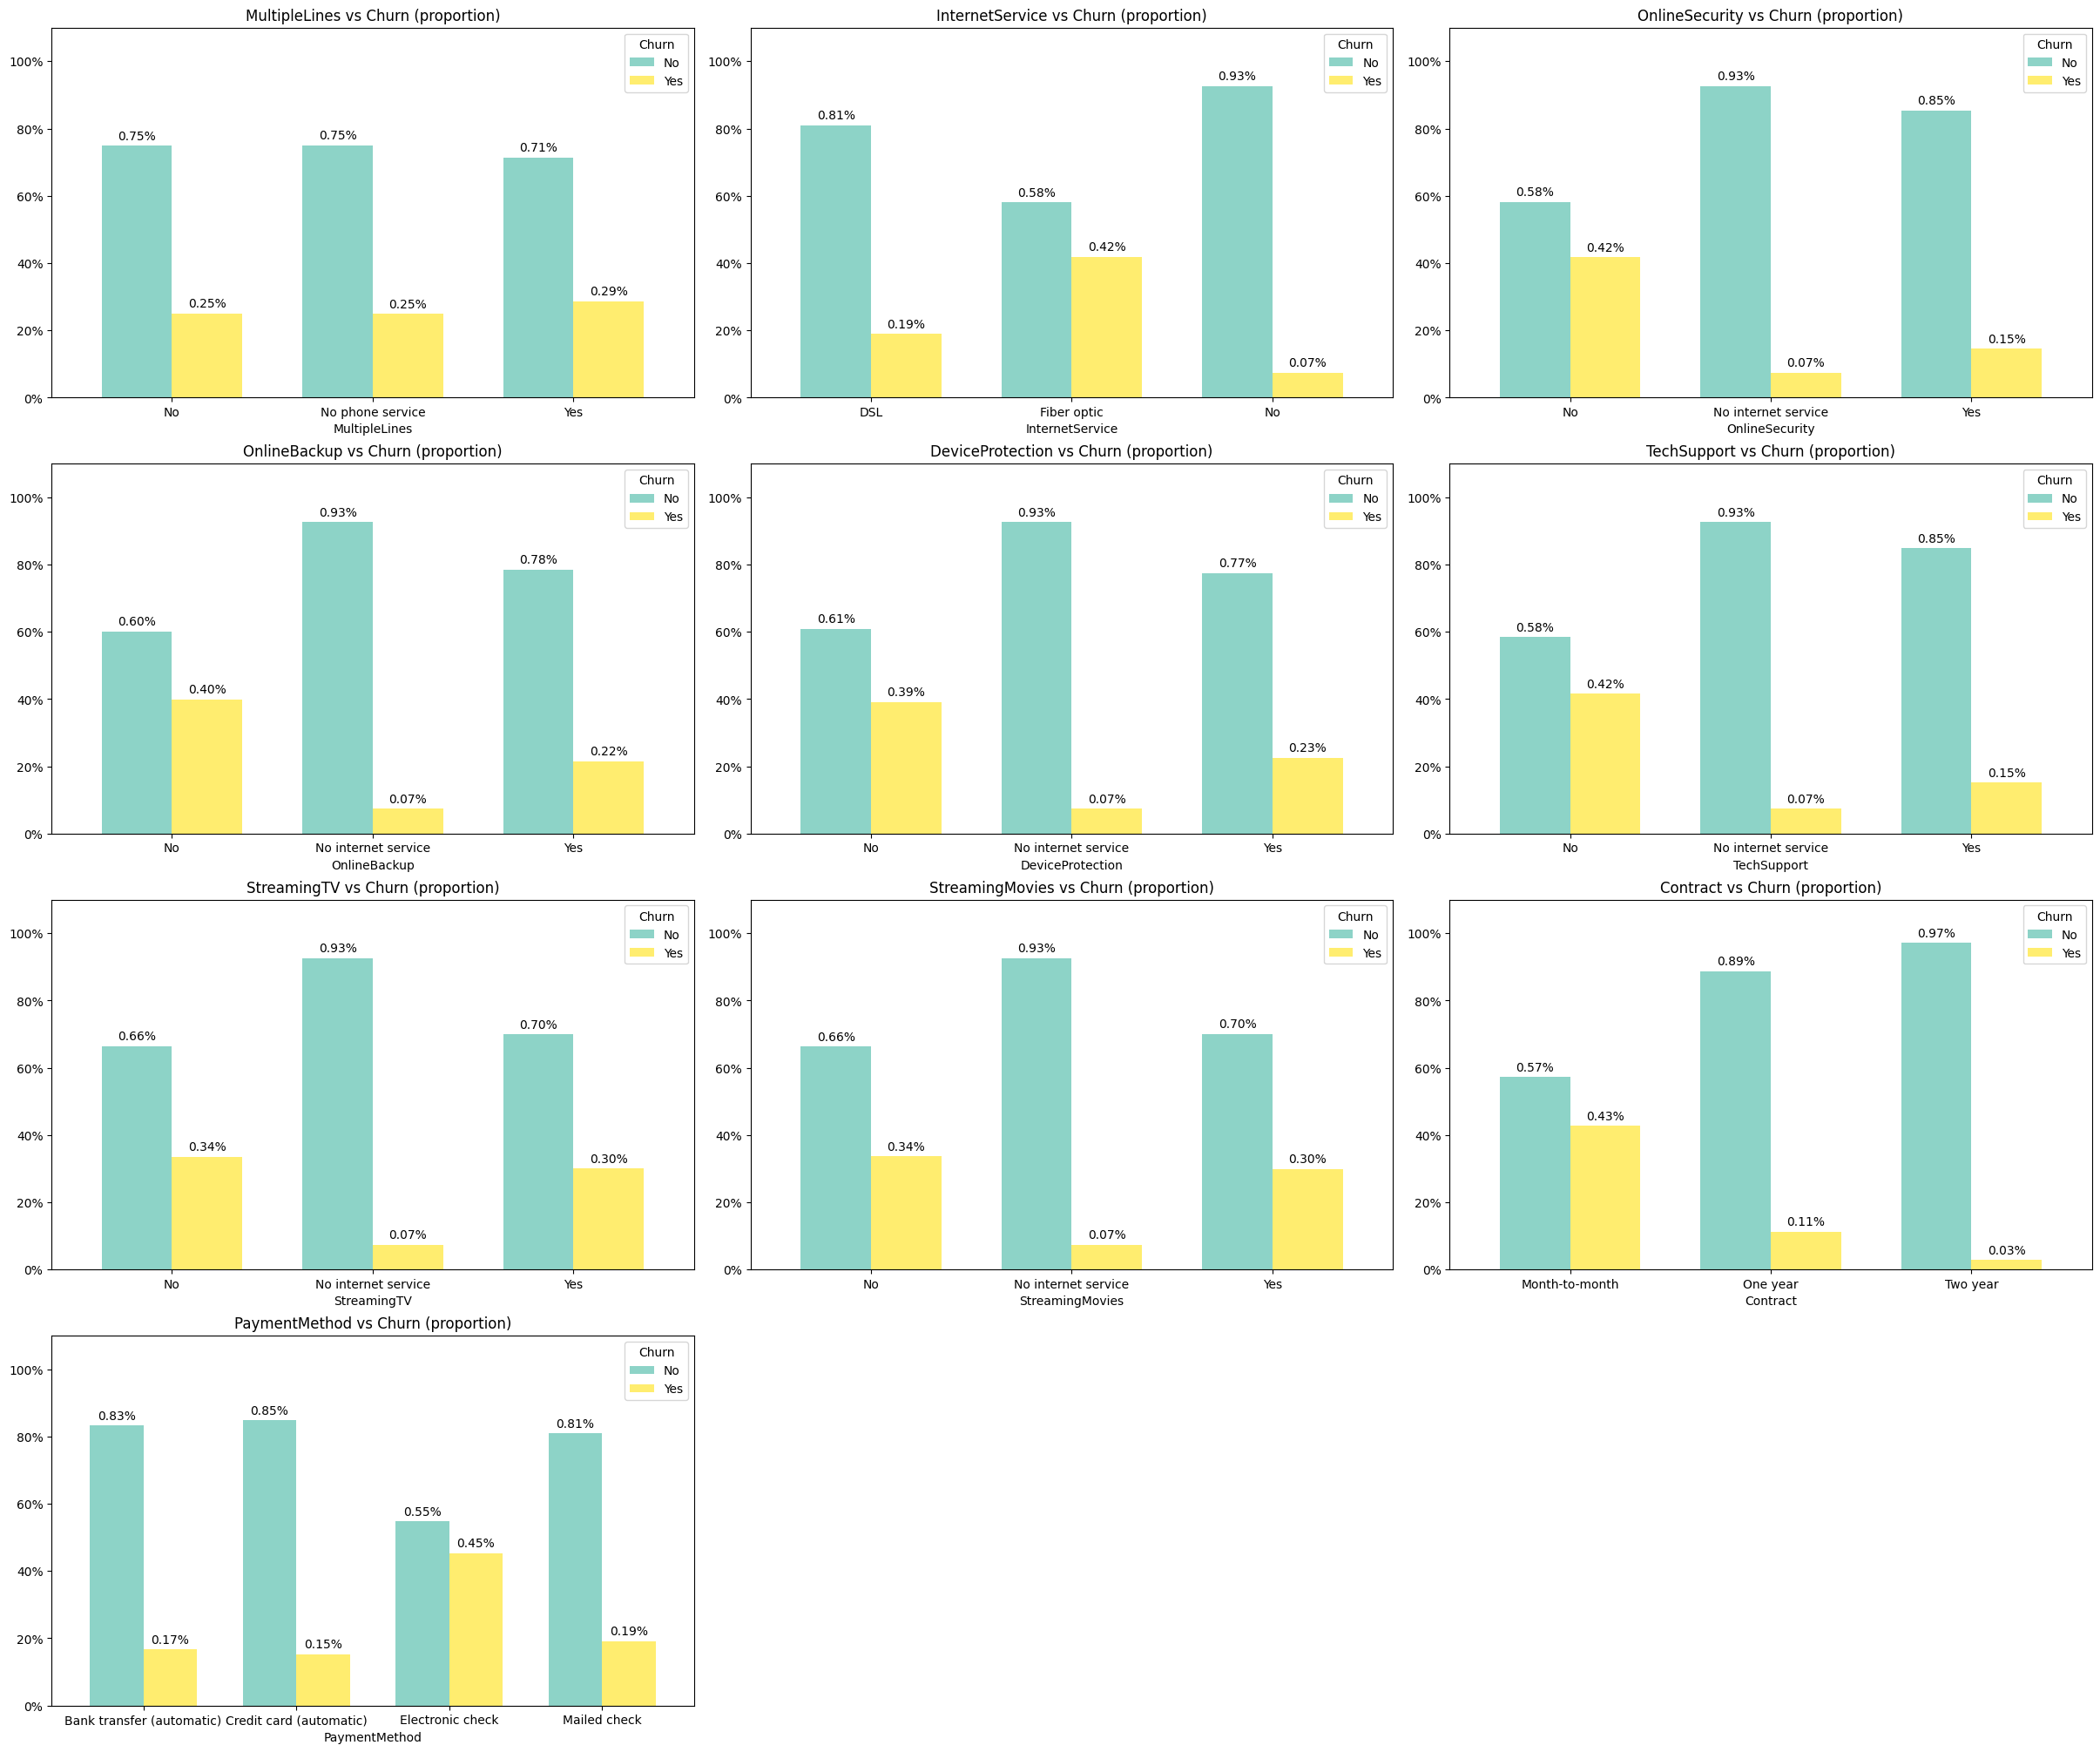

In [ ]:
# Observar de que forma cada variável se relaciona com a variável alvo ("churn")
# Observando apenas variávels com 3 ou mais categorias.

cat_cols = df_bronze.select_dtypes(include='object').columns
cat_cols = cat_cols.drop(["Churn", "PhoneService", "Partner", "Dependents", "gender", "PaperlessBilling", "customerID", "TotalCharges"])

n = len(cat_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*5), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    ctab = pd.crosstab(df_bronze[col], df_bronze['Churn'], normalize='index')
    ctab.plot(kind='bar', ax=ax, width=0.7, colormap='Set3')

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"{col} vs Churn (proportion)")
    ax.set_xlabel(col)
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title='Churn')

    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f%%', label_type='edge', padding=3)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

Análise:
- A hipótese 2 já pode ser respondida A partir dessa análise. Claramente clientes com contratos de 1 ou 2 anos possuem taxas de Churn mais baixas do que os clientes que renovam suas assinaturas mês a mês.

- Observar como cada categoria se relaciona com a variável alvo é muito importante pra entender como manipular as variáveis e suas categorias. Esse estudo irá guiar ações como a fusão de categorias e a escolha das variáveis usadas em Machine Learning. Por exemplo: na variável "MultipleLines" as 3 categorias se relacionam com "churn" de formas muito semelhantes, logo essa variável pode ser descartada para treinamento de um modelo de ML.

- Por outro lado, as categorias da variável "OnlineSecurity" possuem comportamentos bem distintos em relação à variável "churn". Além disso, existe um fato interessante, As categorias "yes" e "no internet service" possuem comportamentos semelhantes. Fato que pode ser considerado contra-intuitivo.

- Através dessa análise pode-se compreender que os relacionamentos de cada categoria das variáveis com a variável alvo pode ser o elemento chave para conseguir um bom modelo preditivo para esse problema.

## Limpeza e Transformação

Esta etapa será dividida em três partes, ou variações. Cada parte resultará em um conjunto de dados com tratamentos diferentes.

A ideia aqui é entender o resultado das transformações dos dados no desempenho dos modelos preditivos.

In [ ]:
# Etapa comum às três variações
df_silver = df_bronze.copy()

# Corrigindo o dtype da coluna "TotalCharges"
df_silver["TotalCharges"] = pd.to_numeric(df_silver["TotalCharges"], errors="coerce")
df_silver.dropna(subset=["TotalCharges"], inplace=True)

# Corrigindo o dtype da coluna "SeniorCitizen"
df_silver["SeniorCitizen"] = df_silver["SeniorCitizen"].astype("object")

# descartando a variável "customerID"
df_silver.drop(columns=["customerID"], inplace=True)

df_silver.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df_silver.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


### Variação 1

As variáveis serão transformadas em binárias, levando em consideração uma visão superficial. Sem considerar a relação das categorias com a variável alvo.

In [ ]:
df_silver_v1 = df_silver.copy()

# Mapeando as categorias para valores binários
general_mapping = {"No internet service": "No", "No phone service": "No",
                   "DSL": "No", "Fiber optic": "Yes", "Month-to-month": "No",
                   "One year": "Yes", "Two year": "Yes", "Electronic check": "No",
                   "Mailed check": "No", "Bank transfer (automatic)": "Yes",
                   "Credit card (automatic)": "Yes"}

df_silver_v1 = df_silver_v1.replace(general_mapping)

# Transformando em variáveis numéricas
numeric_mapping = {"Yes": 1, "No": 0,
                   "Male": 1, "Female": 0}
df_silver_v1 = df_silver_v1.replace(numeric_mapping)

# Padronizando as variáveis numéricas para média = 0 e desvio padrão = 1
standarize_features = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
df_silver_v1[standarize_features] = scaler.fit_transform(df_silver_v1[standarize_features])

print(df_silver_v1.shape)
df_silver_v1.head(2)

(7032, 20)


/tmp/ipython-input-11-3960690130.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_silver_v1 = df_silver_v1.replace(general_mapping)
/tmp/ipython-input-11-3960690130.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_silver_v1 = df_silver_v1.replace(numeric_mapping)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.280248,0,0,0,0,1,0,0,0,0,0,1,0,-1.161694,-0.994194,0
1,1,0,0,0,0.064303,1,0,0,1,0,1,0,0,0,1,0,0,-0.260878,-0.173740,0


### Variação 2

As variáveis serão transformadas em binárias quando houverem categorias com comportamentos parecidos e levando em consideração as relações das categorias com a variável alvo.

In [ ]:
df_silver_v2 = df_silver.copy()

# Mapeando as categorias para valores binários
internetservice_mapping = {"DSL": "No", "Fiber optic": "Yes",}
nointernetservice_mapping = {"No internet service": "Yes",}
nophoneservice_mapping = { "No phone service": "No",}
contract_mapping = {"Month-to-month": "No", "One year": "Yes", "Two year": "Yes",}
paymentmethod_mapping = {"Bank transfer (automatic)": "Yes",
                         "Credit card (automatic)": "Yes",
                         "Electronic check": "No",
                         "Mailed check": "Yes",
                         }
# Aplicando as transformações
df_silver_v2["MultipleLines"] = df_silver_v2["MultipleLines"].replace(nophoneservice_mapping)
df_silver_v2["InternetService"] = df_silver_v2["InternetService"].replace(internetservice_mapping)
df_silver_v2["OnlineSecurity"] = df_silver_v2["OnlineSecurity"].replace(nointernetservice_mapping)
df_silver_v2["OnlineBackup"] = df_silver_v2["OnlineBackup"].replace(nointernetservice_mapping)
df_silver_v2["DeviceProtection"] = df_silver_v2["DeviceProtection"].replace(nointernetservice_mapping)
df_silver_v2["TechSupport"] = df_silver_v2["TechSupport"].replace(nointernetservice_mapping)
df_silver_v2["Contract"] = df_silver_v2["Contract"].replace(contract_mapping)
df_silver_v2["PaymentMethod"] = df_silver_v2["PaymentMethod"].replace(paymentmethod_mapping)

# "StreamingTV" e "StreamingMovies" não seguem o mesmo comportamento, portanto
# Serão tratadas de forma diferente.
one_hot_cols = ["StreamingTV", "StreamingMovies"]
df_silver_v2 = pd.get_dummies(df_silver_v2, columns=one_hot_cols, drop_first=False)

# Transformando em variáveis numéricas
numeric_mapping = {"Yes": 1, "No": 0,
                   True: 1, False: 0,
                   "Male": 1, "Female": 0}
df_silver_v2 = df_silver_v2.replace(numeric_mapping)

# Padronizando as variáveis numéricas para média = 0 e desvio padrão = 1
standarize_features = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
df_silver_v2[standarize_features] = scaler.fit_transform(df_silver_v2[standarize_features])

print(df_silver_v2.shape)
df_silver_v2.head(2)

/tmp/ipython-input-12-2722367611.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_silver_v2 = df_silver_v2.replace(numeric_mapping)


(7032, 24)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,0,1,0,-1.280248,0,0,0,0,1,...,0,-1.161694,-0.994194,0,1,0,0,1,0,0
1,1,0,0,0,0.064303,1,0,0,1,0,...,1,-0.260878,-0.173740,0,1,0,0,1,0,0


### Variação 3

As variáveis não serão transformadas em binárias. Nessa variação as variáveis categóricas serão codificadas com OneHot encoder.

In [ ]:
df_silver_v3 = df_silver.copy()

# Removendo a variável "MultipleLines" pois todas as categorias possuem o mesmo
# comportamento relativo à variável alvo
df_silver_v3.drop(columns=["MultipleLines"], inplace=True)

# Obtendo as colunas categóricas
categorical_cols = df_silver_v3.select_dtypes(include='object').columns.tolist()
# Adicionando a variável "SeniorCitizen" na lista das categóricas
categorical_cols.append("SeniorCitizen")
# Removendo as variáveis binárias da lista
binary_features = ["Churn", "PhoneService", "Partner", "Dependents", "gender", "PaperlessBilling"]
categorical_cols = [feature for feature in categorical_cols if feature not in binary_features]

# Transformando as variáveis binárias
df_silver_v3[binary_features] = df_silver_v3[binary_features].replace({"Yes": 1, "No": 0,
                                                                 "Male": 1, "Female": 0})

# Usando OneHot Encoder para transofrmar as variáveis categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_array = encoder.fit_transform(df_silver_v3[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df_silver_v3.index)

# Descartando as colunas antigas e unindo as variáveis codificadas no conjunto de dados
df_silver_noncat = df_silver_v3.drop(columns=categorical_cols)
df_silver_v3 = pd.concat([df_silver_noncat, encoded_df], axis=1)

# Padronizando as variáveis numéricas para média = 0 e desvio padrão = 1
standarize_features = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
df_silver_v3[standarize_features] = scaler.fit_transform(df_silver_v3[standarize_features])

print(df_silver_v3.shape)
df_silver_v3.head(2)

(7032, 41)


/tmp/ipython-input-13-1399645324.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_silver_v3[binary_features] = df_silver_v3[binary_features].replace({"Yes": 1, "No": 0,


,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen_0,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_0,SeniorCitizen_1
0,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,0,0,0.064303,1,0,-0.260878,-0.173740,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Treinando os modelos preditivos

In [ ]:
# Instanciando os classificadores e definindo parâmetros.
classificadores = {
    'rl': LogisticRegression(random_state=SEED),
    'rf': RandomForestClassifier(max_depth=4, random_state=SEED,
                                 class_weight='balanced'),
}

### Variação 1

In [ ]:
X_1 = df_silver_v1.drop(columns=["Churn"])
y_1 = df_silver_v1["Churn"]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=SEED, stratify=y_1)

for name, clf in classificadores.items():
    print(f"Training {name}...")
    clf.fit(X_train_1, y_train_1)
    y_pred_1 = clf.predict(X_test_1)

    acc = accuracy_score(y_test_1, y_pred_1)
    result_dict_v1 = classification_report(y_test_1, y_pred_1, output_dict=True)
    print(f"Accuracy for {name}: {acc:.4f}")
    print(f"Classification report for {name}:\n", classification_report(y_test_1, y_pred_1))
    print("-" * 60)

Training rl...
Accuracy for rl: 0.8095
Classification report for rl:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.55      0.61       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110

------------------------------------------------------------
Training rf...
Accuracy for rf: 0.7408
Classification report for rf:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1549
           1       0.51      0.81      0.63       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.81      0.74      0.75      2110

------------------------------------------------------------


### Variação 2

In [ ]:
X_2 = df_silver_v2.drop(columns=["Churn"])
y_2 = df_silver_v2["Churn"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=SEED, stratify=y_2)

for name, clf in classificadores.items():
    print(f"Training {name}...")
    clf.fit(X_train_2, y_train_2)
    y_pred_2 = clf.predict(X_test_2)

    acc = accuracy_score(y_test_2, y_pred_2)
    result_dict_v2 = classification_report(y_test_2, y_pred_2, output_dict=True)
    print(f"Accuracy for {name}: {acc:.4f}")
    print(f"Classification report for {name}:\n", classification_report(y_test_2, y_pred_2))
    print("-" * 60)

Training rl...
Accuracy for rl: 0.8085
Classification report for rl:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110

------------------------------------------------------------
Training rf...
Accuracy for rf: 0.7502
Classification report for rf:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1549
           1       0.52      0.80      0.63       561

    accuracy                           0.75      2110
   macro avg       0.71      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110

------------------------------------------------------------


### Variação 3

In [ ]:
X_3 = df_silver_v3.drop(columns=["Churn"])
y_3 = df_silver_v3["Churn"]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=SEED, stratify=y_3)

for name, clf in classificadores.items():
    print(f"Training {name}...")
    clf.fit(X_train_3, y_train_3)
    y_pred_3 = clf.predict(X_test_3)

    acc = accuracy_score(y_test_3, y_pred_3)
    result_dict_v3 = classification_report(y_test_3, y_pred_3, output_dict=True)
    print(f"Accuracy for {name}: {acc:.4f}")
    print(f"Classification report for {name}:\n", classification_report(y_test_3, y_pred_3))
    print("-" * 60)

Training rl...
Accuracy for rl: 0.8085
Classification report for rl:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110

------------------------------------------------------------
Training rf...
Accuracy for rf: 0.7379
Classification report for rf:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1549
           1       0.50      0.80      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.75      2110

------------------------------------------------------------


## Comparando os resultados do algoritmo de Random Forests

In [ ]:
results = {}

# Example: for each model, save only the two f1-scores
results['variacao_1'] = {
    'f1_macro': result_dict_v1['macro avg']['f1-score'],
    'f1_weighted': result_dict_v1['weighted avg']['f1-score']
}

results['variacao_2'] = {
    'f1_macro': result_dict_v2['macro avg']['f1-score'],
    'f1_weighted': result_dict_v2['weighted avg']['f1-score']
}

results['variacao_3'] = {
    'f1_macro': result_dict_v3['macro avg']['f1-score'],
    'f1_weighted': result_dict_v3['weighted avg']['f1-score']
}

# Convert to DataFrame
df_random_forests = pd.DataFrame.from_dict(results, orient='index')

# Optional: round and sort
df_random_forests = df_random_forests.round(3)

df_random_forests

,f1_macro,f1_weighted
variacao_1,0.714,0.755
variacao_2,0.721,0.763
variacao_3,0.710,0.752


Relembrando cada variação:
- 1: As variáveis serão transformadas em binárias, levando em consideração uma visão superficial. Sem considerar a relação das categorias com a variável alvo.


- 2: As variáveis serão transformadas em binárias quando houverem categorias com comportamentos parecidos e levando em consideração as relações das categorias com a variável alvo.


- 3: As variáveis não serão transformadas em binárias. Nessa variação as variáveis categóricas serão codificadas com OneHot encoder.

Análise:

Hipótese 1:

Transformar de forma adequada as variáveis categóricas em binárias pode melhorar o desempenho de modelos preditivos nesse problema.


Resultado:

Comparando as métricas da variações 1 e 2 observa-se que o impacto nos escores F1 foi muito pequeno. Essa diferença pode, inclusive, ser atribuída ao acaso.
Para tentar entender melhor pode-se medir o impacto de cada variável no treinamento de um modelo. Essa medição será feita na próxima etapa.

## Observando a importância de cada variável
Nessa etapa a importância das variáveis será estimada utilizando o método feature_importances_ da classe RandomForestClassifier.

As três variações serão observadas.

In [ ]:
# Variação 1
rf_1 = RandomForestClassifier(max_depth=4, random_state=SEED, class_weight='balanced')
rf_1.fit(X_train_1, y_train_1)

importances_1 = rf_1.feature_importances_
feature_names_1 = X_1.columns
feature_importances_1 = pd.Series(importances_1, index=feature_names_1)


# Variação 2
rf_2 = RandomForestClassifier(max_depth=4, random_state=SEED, class_weight='balanced')
rf_2.fit(X_train_2, y_train_2)

importances_2 = rf_2.feature_importances_
feature_names_2 = X_2.columns
feature_importances_2 = pd.Series(importances_2, index=feature_names_2)



# Variação 3
rf_3 = RandomForestClassifier(max_depth=4, random_state=SEED, class_weight='balanced')
rf_3.fit(X_train_3, y_train_3)

importances_3 = rf_3.feature_importances_
feature_names_3 = X_3.columns
feature_importances_3 = pd.Series(importances_3, index=feature_names_3)

# Unindo os dados de impórtância das variáveis
feature_importances_1 = feature_importances_1[~feature_importances_1.index.duplicated()]
feature_importances_2 = feature_importances_2[~feature_importances_2.index.duplicated()]
feature_importances_3 = feature_importances_3[~feature_importances_3.index.duplicated()]

df_importances = pd.concat([
    feature_importances_1.rename("v1"),
    feature_importances_2.rename("v2"),
    feature_importances_3.rename("v3")
], axis=1)

df_importances

,v1,v2,v3
gender,0.000438,0.000545,0.000255
SeniorCitizen,0.011192,0.004135,NaN
Partner,0.005286,0.004934,0.002929
Dependents,0.012225,0.002960,0.002080
tenure,0.199197,0.134973,0.093204
PhoneService,0.004127,0.000640,0.000311
MultipleLines,0.002931,0.002165,NaN
InternetService,0.127391,0.081728,NaN
OnlineSecurity,0.027249,0.123537,NaN
OnlineBackup,0.002997,0.034190,NaN


Análise:
As variáveis transformadas de acordo com o comportamento de suas categorias em relação à variável alvo obtiveram um aumento considerável de importância. Algumas tiveram seu impacto melhorado em mais de 10 vezes. Os exemplos são:
- "OnlineSecurity" de	0.027249 para	0.123537
- "OnlineBackup" de 0.002997	para 0.034190
- "TechSupport" de	0.022184	para 0.099064

O escore final pode não ter espelhado estes resultados de forma tão clara por alguns motivos. Na próxima etapa serão feitos outros tratamentos pertencentes ao conjunto das boas práticas de Machine Learning.

## Treinando um modelo preditivo
Nessa seção, será utilizado o conjunto de boas práticas de ciência de dados e Machine Learning para treinamento de um modelo preditivo visando obter um desempenho mais robusto.

Trabalhando novamente o conjunto de dados da variação 2.

### Seleção de variáveis

In [ ]:
# Seleção de variáveis embasada na lista de importância
test_001_features = df_importances[df_importances["v2"] >= 0.01]["v2"].index.to_list()
print(test_001_features)

test_005_features = df_importances[df_importances["v2"] >= 0.05]["v2"].index.to_list()
print(test_005_features)

test_01_features = df_importances[df_importances["v2"] >= 0.1]["v2"].index.to_list()
print(test_01_features)

['tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']
['tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
['tenure', 'OnlineSecurity', 'Contract']


### Verificando se há correlação entre variáveis

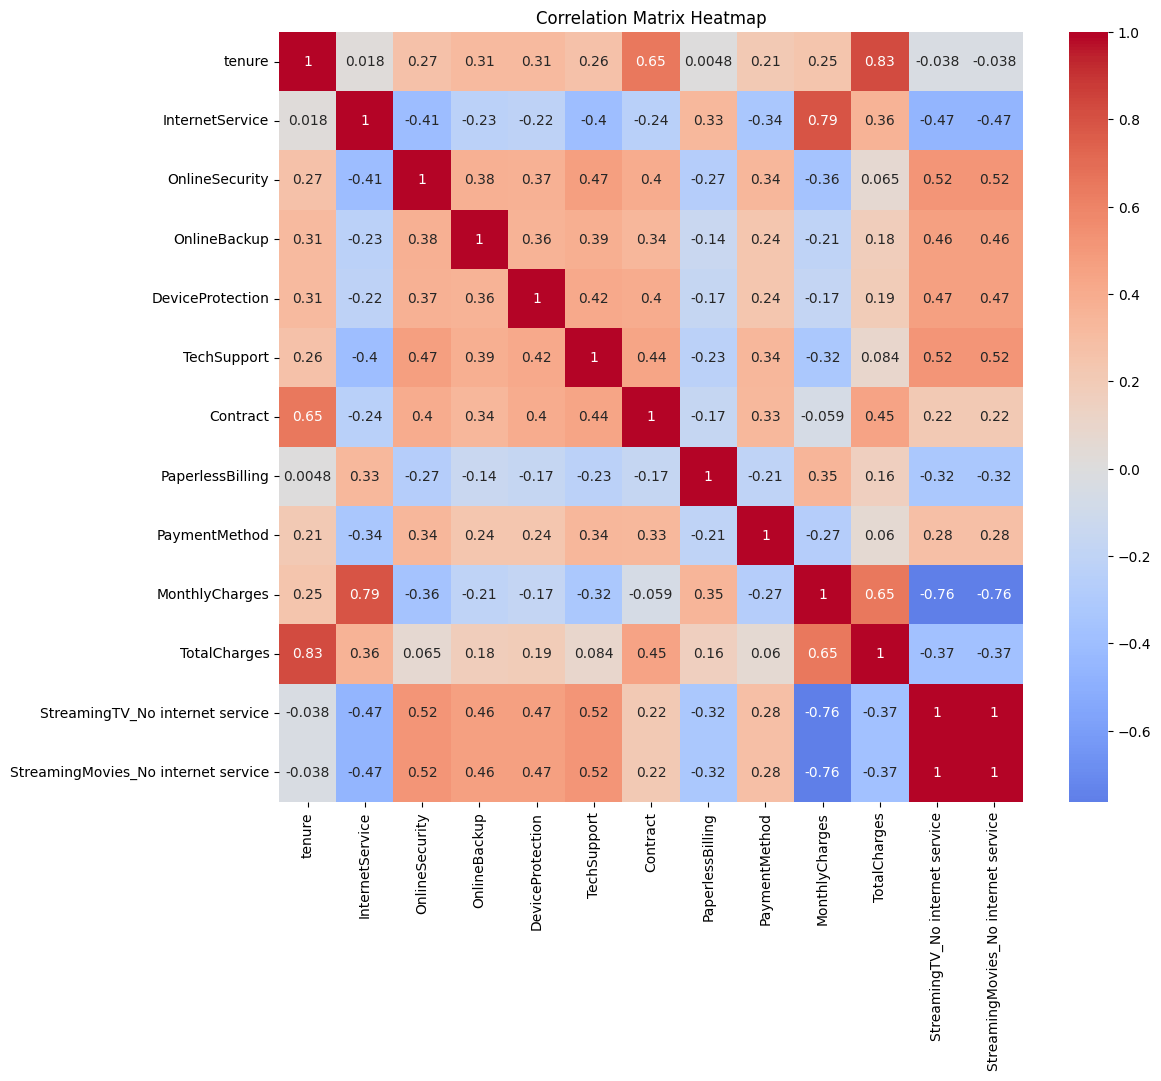

In [ ]:
X = df_silver_v2[test_001_features]
corr_matrix = X.corr()

# Mapa de calor
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

Análise:

Existem correlações importantes entre algumas das variáveis utilizadas para treinamento dos preditoers. Alguns exemplos são: "Tenure" e "TotalCharges" com 83%; "Tenure" e "Contract" com 65%; "MonthlyCharges" e "StreamingTV_No internet service" com -76%.

Observa-se também que ao selecionar apenas variáveis com importância de 10% ou mais, temos três variáveis resultantes. Duas delas possuem correlação positiva de 65%.

Ainda assim não, se pode atribuir impacto negativo nos resultados do preditor RandomForestClassifier a esse fato. Modelos baseados em árvore de decisão não são afetados por correlação entre variáveis explicativas, pois não são modelos "ingênuos", ou seja, não assumem independência entre as variáveis.



### Treinando os modelos com as seleções de variáveis

In [ ]:
# Modularizando o treinamento e o cálculo de desempenho do modelo
def calc_model_performance(df, features_list):
  '''
  Recebe X, y e a lista de variáveis e executa toda a pipeline de treino
  e cálculo de métricas de desempenho
  '''

  X = df[features_list]
  y = df["Churn"]

  # Separação de amostras para treino e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

  # Utilizando RandomizedSearchCV para buscar melhores configurações de hiperparâmetros
  param_settings = {
    'rf__n_estimators': randint(100, 1000),
    'rf__max_depth': [None] + list(range(4, 20, 2)),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
    'rf__max_features': ['sqrt', 'log2']
  }

  # Definindo a pipeline de forma simples
  pipeline = Pipeline([('rf',
                        RandomForestClassifier(random_state=SEED,
                                              class_weight='balanced',
                                              n_jobs=-1))
  ])

  # Aplicando Random Search com validação cruzada
  random_search = RandomizedSearchCV(
      pipeline,
      param_distributions=param_settings,
      n_iter=30,
      scoring='f1_weighted',
      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
      random_state=SEED,
      verbose=1,
      n_jobs=-1
  )

  random_search.fit(X_train, y_train)

  # Testando os resultados
  y_pred = random_search.predict(X_test)
  print("Melhores parâmetros:", random_search.best_params_)
  return classification_report(y_test, y_pred)


In [ ]:
# Resultados obtidos com as variáveis com importância 1% ou maior
result_001 = calc_model_performance(df=df_silver_v2, features_list=test_001_features)
print(result_001)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'rf__max_depth': 16, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 6, 'rf__n_estimators': 240}
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1549
           1       0.56      0.71      0.63       561

    accuracy                           0.78      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.80      0.78      0.78      2110



In [ ]:
# Resultados obtidos com as variáveis com importância 5% ou maior
result_005 = calc_model_performance(df=df_silver_v2, features_list=test_005_features)
print(result_005)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1549
           1       0.55      0.70      0.62       561

    accuracy                           0.77      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.79      0.77      0.78      2110



In [ ]:
# Resultados obtidos com as variáveis com importância 10% ou maior
result_01 = calc_model_performance(df=df_silver_v2, features_list=test_01_features)
print(result_01)

              precision    recall  f1-score   support

           0       0.89      0.73      0.81      1549
           1       0.51      0.76      0.61       561

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.79      0.74      0.75      2110



Análise:

A seleção de variáveis e a utilização de Random Search foram capazes de melhorar o escore F1 de 76,3% para aproximadamente 78,0%.

No caso da utilização apenas de variáveis com 10% de importância ou mais, o resultado foi o inverso, o desempenho caiu. Esse fato pode ser causado pelo número reduzido de variáveis usadas. Apenas 3.

### Teste da Hipótese 3

Para esse teste, será usado apenas um modelo de regressão logística, pois esse não possui nenhum mecanismo para balanceamento de classes.

In [ ]:
# Aplicacção sem undersampling

# Definindo a pipeline
basic_pipeline = Pipeline([
    ('classifier', LogisticRegression(random_state=SEED))
])

X = df_silver_v2.drop(columns=["Churn"])
y = df_silver_v2["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

# treinando e predizendo os valores
basic_pipeline.fit(X_train, y_train)
y_pred_under = basic_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_under))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.56      0.61       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
# Usando Undesample aleatório

# Definindo a pipeline
undersample_pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=SEED)),
    ('classifier', LogisticRegression(random_state=SEED))
])

X = df_silver_v2.drop(columns=["Churn"])
y = df_silver_v2["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

# treinando e predizendo os valores
undersample_pipeline.fit(X_train, y_train)
X_resampled, y_resampled = undersample_pipeline.named_steps['undersample'].fit_resample(X_train, y_train)
y_pred_under = undersample_pipeline.predict(X_test)

print("Número de linhas após o undersampling:",len(X_resampled))
print(classification_report(y_test, y_pred_under))

Número de linhas após o undersampling: 2616
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1549
           1       0.52      0.80      0.63       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110



Anlálise:

A Hipótese 3 é falsa. Usar undersampling aleatório causou redução no escore F1. Essa piora pode er atribuída à redução de dados utilizados para treino e teste.

Observa-se também, que o escore F1 para a classe "1" melhora de 61% para 63% com o undersampling. Isso se dá por que o modelo "atribui" um peso maior para essa classe durante o treino. Na situação original, onde há muito mais casos da classe "0" esse peso maior de aprendizagem é atribuído à essa classe.

#### ALERTA DE LONGO TEMPO DE PROCESSAMENTO DA CÉLULA ABAIXO
### Teste da hipótese 4

Hipótese 4: É poissível obter o mesmo desempenho de um modelo preditivo usando apenas 5 variáveis explicativas.

Treinando modelo de regressão logística com apenas variáveis selecionadas adequadamente. O melhor preditor usando Regressão Logística atingiu escore F1 de 0.80 usando 23 variáveis explicativas.

In [ ]:
## --- ALERTA DE LONGO TEMPO DE PROCESSAMENTO --- ###

# X = df_silver_v2.drop(columns=["Churn"])
# y = df_silver_v2["Churn"]

# model = LogisticRegression(random_state=SEED)

# # Cálculo do escore F1
# f1_scorer = make_scorer(f1_score, average='weighted')
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# # Obtendo a lista exaustiva de combinações.
# feature_names = X.columns.tolist()
# combinations = list(itertools.combinations(feature_names, 5))

# results = []
# for combo in tqdm(combinations):
#     X_subset = X[list(combo)]
#     f1 = cross_val_score(model, X_subset, y, cv=cv, scoring=f1_scorer).mean()
#     results.append((combo, f1))

# # Ordenando e exibindo os resultados
# results = sorted(results, key=lambda x: x[1], reverse=True)
# top_results = pd.DataFrame(results, columns=["Features", "F1_Score"])
# print(top_results.head(10))

100%|██████████| 33649/33649 [1:05:06<00:00,  8.61it/s]

                                            Features  F1_Score
0  (tenure, PhoneService, InternetService, Paymen...  0.790615
1  (tenure, InternetService, Contract, PaymentMet...  0.789880
2  (SeniorCitizen, tenure, PhoneService, Internet...  0.789674
3  (tenure, PhoneService, InternetService, Contra...  0.789356
4  (tenure, PhoneService, TechSupport, PaperlessB...  0.789127
5  (tenure, PhoneService, MultipleLines, Internet...  0.788928
6  (tenure, InternetService, OnlineSecurity, Tech...  0.788345
7  (tenure, PhoneService, TechSupport, PaymentMet...  0.787952
8  (tenure, InternetService, TechSupport, Paperle...  0.787815
9  (tenure, PhoneService, InternetService, Paymen...  0.787644


In [ ]:
# # backup devido o longo tempo de processamento
# for item in top_results.values[:3]:
#   print(item)

'''
[('tenure', 'PhoneService', 'InternetService', 'PaymentMethod', 'StreamingMovies_Yes')
 0.7906146330588666]
[('tenure', 'InternetService', 'Contract', 'PaymentMethod', 'StreamingMovies_Yes')
 0.789879950028785]
[('SeniorCitizen', 'tenure', 'PhoneService', 'InternetService', 'PaymentMethod')
 0.7896735072216778]
'''

[('tenure', 'PhoneService', 'InternetService', 'PaymentMethod', 'StreamingMovies_Yes')
 0.7906146330588666]
[('tenure', 'InternetService', 'Contract', 'PaymentMethod', 'StreamingMovies_Yes')
 0.789879950028785]
[('SeniorCitizen', 'tenure', 'PhoneService', 'InternetService', 'PaymentMethod')
 0.7896735072216778]


"\n[('tenure', 'PhoneService', 'InternetService', 'PaymentMethod', 'StreamingMovies_Yes')\n 0.7906146330588666]\n[('tenure', 'InternetService', 'Contract', 'PaymentMethod', 'StreamingMovies_Yes')\n 0.789879950028785]\n[('SeniorCitizen', 'tenure', 'PhoneService', 'InternetService', 'PaymentMethod')\n 0.7896735072216778]\n"

Análise:

Observa-se que a hipótese 4 é falsa. Após testar exaustivamente todas as combinações de 5 variáveis, nenhuma obteve escore F1 maior que 0,8.

Outro fato interessante é que a única variável numérica presente no top 3 de melhores desempenhos é "tenure".

## Conclusões:

### Respostas das Hipóteses:
- Hipótese 1:
Transformar de forma adequada as variáveis categóricas em binárias pode melhorar o desempenho de modelos preditivos nesse problema.

 - Resultado:
Comparando as métricas da variações 1 e 2 observa-se que o impacto nos escores F1 foi muito pequeno. Essa diferença pode, inclusive, ser atribuída ao acaso. Para tentar entender melhor pode-se medir o impacto de cada variável no treinamento de um modelo. Essa medição será feita na próxima etapa.

- Hipótese 2:
Incentivar contratos mais longos pode reduzir a taxa de churn.
 - Resultado:
  Claramente clientes com contratos de 1 ou 2 anos possuem taxas de Churn mais baixas, (respectivamente 11% e 3%), do que os clientes que renovam suas assinaturas mês a mês (Churn de 43%).

- Hipótese 3:
Usar apenas undersampling simples para balancear os dados pode ter impacto positivo em modelos preditivos.
 - Resultado:
 A Hipótese 3 está errada. Usar undersampling aleatório causou redução no escore F1. Essa piora pode er atribuída à redução de dados utilizados para treino e teste.

- Hipótese 4:
É poissível obter o mesmo desempenho de um modelo preditivo usando apenas 5 variáveis explicativas.
 - Resultado:
Observa-se que a hipótese 4 é falsa. Após testar exaustivamente todas as combinações de 5 variáveis, nenhuma obteve escore F1 maior que 0,8.

### Conclusões gerais

- O conjunto de dados usado traz uma facilidade inicial, não há valores faltantes ou nulos. Isso facilita a etapa de análise e limpeza. Em contrapartida, apresenta dificuldade na etapa de treino dos modelos preditivos. Embora seja um problema relativamente simples de classificação binária, atingir escore F1 acima de 80% se mostrou um desafio.

- Algumas das ideias iniciais se mostraram difíceis de testar ou erradas. Outras, embora corretas, foram pouco eficazes para melhorar o desempenho dos modelos preditores.